In [ ]:
import copy
import math
import time
from typing import List, Optional

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer

sns.set_theme(context="notebook", palette="deep")

# 1. Реализовать кернель для квантизации 2D матрицы из fp16 в int4 и последующей упаковки квантизованной матрицы в int8 или **int32**.
При этом потребляемая память должна уменьшиться в 4 раза.

In [ ]:
from kernels.global_quant import dequant_global_int4_int32, quant_global_int4_int32
from kernels.groupwise_quant import dequant_groupwise_int4_int32, quant_groupwise_int4_int32
from kernels.rowwise_quant import dequant_rowwise_int4_int32, quant_rowwise_int4_int32

In [ ]:
def mae(x: torch.Tensor, quant_func, dequant_func, eps: float = 1e-8, **kwargs):
    q, scales = quant_func(x, **kwargs)
    x_deq = dequant_func(q, scales, **kwargs)
    diff = (x_deq - x).float()
    abs_diff = diff.abs()
    mae = abs_diff.mean().item()
    return mae


def tensor_nbytes(t: torch.Tensor):
    return t.numel() * t.element_size()


def qtime(x: torch.Tensor, quant_func, dequant_func, **kwargs):
    torch.cuda.synchronize()
    t0 = time.time()
    q, scales = quant_func(x, **kwargs)
    torch.cuda.synchronize()
    t1 = time.time()
    x_deq = dequant_func(q, scales, **kwargs)
    torch.cuda.synchronize()
    t2 = time.time()
    t_quant_ms = (t1 - t0) * 1000
    t_dequant_ms = (t2 - t1) * 1000
    return t_quant_ms, t_dequant_ms


def compression_size(x: torch.Tensor, quant_func, dequant_func, **kwargs):
    q, scales = quant_func(x, **kwargs)
    x_deq = dequant_func(q, scales, **kwargs)
    bytes_orig = tensor_nbytes(x)

    bytes_q = tensor_nbytes(q) + tensor_nbytes(scales)
    compression = bytes_orig / bytes_q
    return bytes_orig, bytes_q, compression


def get_dict_metrics(x, quant_func, dequant_func, **kwargs):
    results = {}
    results["mae"] = mae(x, quant_func, dequant_func, **kwargs)
    t_quant_ms, t_dequant_ms = qtime(x, quant_func, dequant_func, **kwargs)
    results["t_quant_ms"] = t_quant_ms
    results["t_dequant_ms"] = t_quant_ms
    bytes_orig, bytes_q, compression = compression_size(x, quant_func, dequant_func, **kwargs)
    results["bytes_orig"] = bytes_orig
    results["bytes_q"] = bytes_q
    results["compression"] = compression
    return results


def compare_quant_schemes(
    n_rows=4096,
    n_cols=4096,
    group_sizes=[16, 32, 64, 128, 256, 512, 1024, 2048, 4096],
    device="cuda",
):
    torch.manual_seed(0)
    x = torch.randn(n_rows, n_cols, device=device, dtype=torch.float16)

    results = {
        "global": [],
        "rowwise": [],
        "groupwise": {gs: [] for gs in group_sizes},
    }

    # -------- GLOBAL --------
    results["global"].append(get_dict_metrics(x, quant_global_int4_int32, dequant_global_int4_int32))

    # -------- ROWWISE --------
    results["rowwise"].append(get_dict_metrics(x, quant_rowwise_int4_int32, dequant_rowwise_int4_int32))

    # -------- GROUPWISE (несколько group_size) --------
    for gs in group_sizes:
        assert gs % 8 == 0, "group_size must be divisible by 8 for int4->int32 packing"
        results["groupwise"][gs].append(
            get_dict_metrics(x, quant_groupwise_int4_int32, dequant_groupwise_int4_int32, group_size=gs)
        )

    return results


def plot_results(results, group_sizes):
    # Графики ошибок и времени для сравнения схем
    # Для groupwise показана зависимость от group_size

    # -------- MAE --------
    plt.figure(figsize=(8, 5))
    mae_global = results["global"][0]["mae"]
    mae_row = results["rowwise"][0]["mae"]
    maes_group = [results["groupwise"][gs][0]["mae"] for gs in group_sizes]

    plt.axhline(mae_global, label="global", linestyle="--", color="C0")
    plt.axhline(mae_row, label="rowwise", linestyle="--", color="C1")
    plt.plot(group_sizes, maes_group, marker="o", label="groupwise (vs group_size)", color="C2")
    plt.xlabel("group_size")
    plt.ylabel("MAE")
    plt.title("MAE vs group_size (global / rowwise / groupwise)")
    plt.legend()
    plt.grid(True)

    # -------- Время квантования --------
    plt.figure(figsize=(8, 5))
    t_global = results["global"][0]["t_quant_ms"]
    t_row = results["rowwise"][0]["t_quant_ms"]
    t_group = [results["groupwise"][gs][0]["t_quant_ms"] for gs in group_sizes]

    plt.axhline(t_global, label="global", linestyle="--", color="C0")
    plt.axhline(t_row, label="rowwise", linestyle="--", color="C1")
    plt.plot(group_sizes, t_group, marker="o", label="groupwise (vs group_size)", color="C2")
    plt.xlabel("group_size")
    plt.ylabel("Quantize time, ms")
    plt.title("Quantize time vs group_size")
    plt.legend()
    plt.grid(True)

    # -------- Коэффициент сжатия --------
    plt.figure(figsize=(8, 5))
    c_global = results["global"][0]["compression"]
    c_row = results["rowwise"][0]["compression"]
    c_group = [results["groupwise"][gs][0]["compression"] for gs in group_sizes]

    plt.axhline(c_global, label="global", linestyle="--", color="C0")
    plt.axhline(c_row, label="rowwise", linestyle="--", color="C1")
    plt.plot(group_sizes, c_group, marker="o", label="groupwise (vs group_size)", color="C2")
    plt.xlabel("group_size")
    plt.ylabel("Compression ratio (orig_bytes / quant_bytes)")
    plt.title("Compression vs group_size")
    plt.legend()
    plt.grid(True)

    plt.show()

GLOBAL:


,mae,t_quant_ms,t_dequant_ms,bytes_orig,bytes_q,compression
0,0.169577,1.974344,1.974344,33554432,8388610,3.999999


ROWWISE:


,mae,t_quant_ms,t_dequant_ms,bytes_orig,bytes_q,compression
0,0.096904,0.810146,0.810146,33554432,8396800,3.996098


GROUPWISE:


,group_size,mae,t_quant_ms,t_dequant_ms,bytes_orig,bytes_q,compression
0,16,0.069842,3.160000,3.160000,33554432,10485760,3.200000
1,32,0.076343,1.875639,1.875639,33554432,9437184,3.555556
2,64,0.082926,1.463652,1.463652,33554432,8912896,3.764706
3,128,0.089447,1.105070,1.105070,33554432,8650752,3.878788
4,256,0.095765,0.922441,0.922441,33554432,8519680,3.938462
5,512,0.101913,0.830650,0.830650,33554432,8454144,3.968992
6,1024,0.107781,0.829458,0.829458,33554432,8421376,3.984436
7,2048,0.113451,0.824213,0.824213,33554432,8404992,3.992203
8,4096,0.118949,0.832081,0.832081,33554432,8396800,3.996098


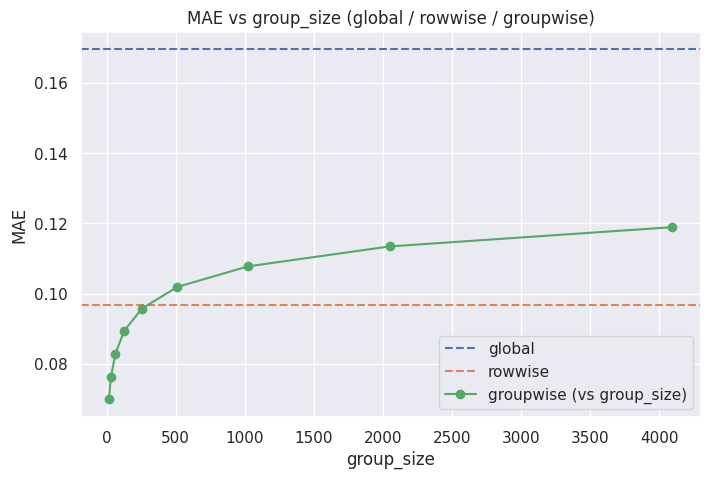

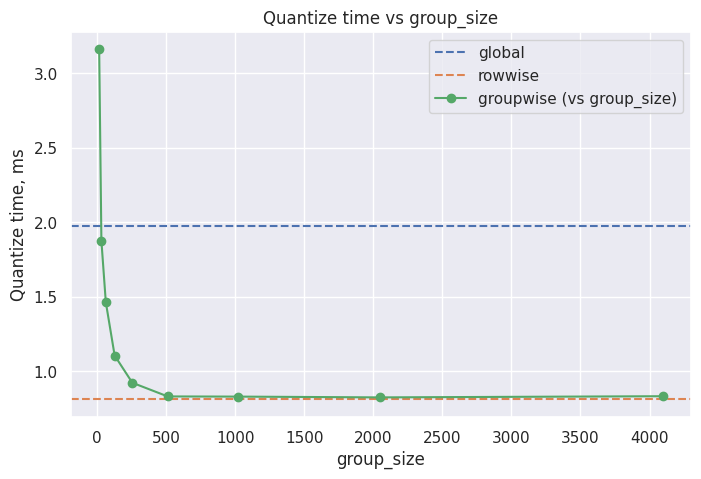

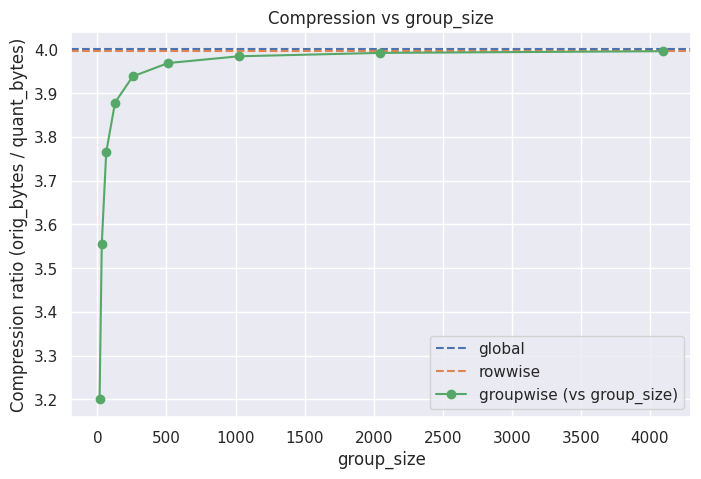

In [ ]:
device = "cuda"
n_rows, n_cols = 4096, 4096
group_sizes = [16, 32, 64, 128, 256, 512, 1024, 2048, 4096]

results = compare_quant_schemes(
    n_rows=n_rows,
    n_cols=n_cols,
    group_sizes=group_sizes,
    device=device,
)
print("GLOBAL:")
display(pd.DataFrame(results["global"]))
print("ROWWISE:")
display(pd.DataFrame(results["rowwise"]))
print("GROUPWISE:")
groupwise = results["groupwise"]
rows = []
for gs, lst in groupwise.items():
    for d in lst:
        row = {"group_size": gs}
        row.update(d)
        rows.append(row)

df = pd.DataFrame(rows)
display(df)

plot_results(results, group_sizes)

# 2. Реализовать кернель для перемножения матрицы в bf16 на квантизованную матрицу в int4 на (X16@W4^T)

In [ ]:
from kernels.unified_matmul import matmul_fp16_int4_unified

# 3. Сравнить скорость перемножения (X16@W4^T) с (X16@W16^T).
Размеры матрицы W такие же, как размеры матриц весов для модели Llama-3.2-1B-Instruct (https://huggingface.co/unsloth/Llama-3.2-1B-Instruct).
Количество строк (токенов) в матрице активаций X: 128, 512, 2048

In [ ]:
# Посмотрим размеры матриц весов у модели

model_name = "unsloth/Llama-3.2-1B-Instruct"
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype="float16")

for name, param in model.named_parameters():
    print(name, param.shape)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/894 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

model.embed_tokens.weight torch.Size([128256, 2048])
model.layers.0.self_attn.q_proj.weight torch.Size([2048, 2048])
model.layers.0.self_attn.k_proj.weight torch.Size([512, 2048])
model.layers.0.self_attn.v_proj.weight torch.Size([512, 2048])
model.layers.0.self_attn.o_proj.weight torch.Size([2048, 2048])
model.layers.0.mlp.gate_proj.weight torch.Size([8192, 2048])
model.layers.0.mlp.up_proj.weight torch.Size([8192, 2048])
model.layers.0.mlp.down_proj.weight torch.Size([2048, 8192])
model.layers.0.input_layernorm.weight torch.Size([2048])
model.layers.0.post_attention_layernorm.weight torch.Size([2048])
model.layers.1.self_attn.q_proj.weight torch.Size([2048, 2048])
model.layers.1.self_attn.k_proj.weight torch.Size([512, 2048])
model.layers.1.self_attn.v_proj.weight torch.Size([512, 2048])
model.layers.1.self_attn.o_proj.weight torch.Size([2048, 2048])
model.layers.1.mlp.gate_proj.weight torch.Size([8192, 2048])
model.layers.1.mlp.up_proj.weight torch.Size([8192, 2048])
model.layers.1.

In [9]:
shapes = set()
for name, param in model.named_parameters():
    shapes.add(tuple(param.shape))

shapes = sorted(shapes, key=lambda s: (len(s), s))

print("Уникальные размеры тензоров весов:")
for s in shapes:
    print(s)

Уникальные размеры тензоров весов:
(2048,)
(512, 2048)
(2048, 2048)
(2048, 8192)
(8192, 2048)
(128256, 2048)


In [ ]:
import pandas as pd
import torch

torch.manual_seed(42)

# ------------------------------------------------------------
# Конфигурации слоёв (K, N)
# ------------------------------------------------------------
layer_configs = [
    (512, 2048),
    (2048, 2048),
    (2048, 8192),
    (8192, 2048),
    (128256, 2048),
]

# Число "токенов" (M)
token_counts = [128, 512, 2048]

GROUP_SIZE = 128

num_warmup = 10
num_iterations = 100

rows = []

for M in token_counts:
    print(f"\n{'=' * 60}")
    print(f"Benchmarking with {M} tokens")
    print(f"{'=' * 60}")

    for K, N in layer_configs:
        print(f"\nLayer: (K={K}, N={N}) - X[{M},{K}] @ W[{N},{K}]^T")

        # Входы и fp16-веса
        X = torch.randn(M, K, device="cuda", dtype=torch.float16)
        W_fp16 = torch.randn(N, K, device="cuda", dtype=torch.float16)

        # ----------------------------
        # fp16 baseline
        # ----------------------------
        # прогрев
        for _ in range(num_warmup):
            _ = torch.matmul(X, W_fp16.t())
        torch.cuda.synchronize()

        start_event = torch.cuda.Event(enable_timing=True)
        end_event = torch.cuda.Event(enable_timing=True)

        start_event.record()
        for _ in range(num_iterations):
            C_fp16 = torch.matmul(X, W_fp16.t())
        end_event.record()
        torch.cuda.synchronize()
        fp16_time = start_event.elapsed_time(end_event) / num_iterations  # ms

        # ----------------------------
        # GLOBAL int4
        # ----------------------------
        W_global_packed, global_max = quant_global_int4_int32(W_fp16)

        # прогрев
        for _ in range(num_warmup):
            _ = matmul_fp16_int4_unified(X, W_global_packed, global_max, mode="global")
        torch.cuda.synchronize()

        start_event.record()
        for _ in range(num_iterations):
            C_global = matmul_fp16_int4_unified(X, W_global_packed, global_max, mode="global")
        end_event.record()
        torch.cuda.synchronize()
        global_time = start_event.elapsed_time(end_event) / num_iterations  # ms

        # ----------------------------
        # ROWWISE int4
        # ----------------------------
        W_row_packed, absmaxs = quant_rowwise_int4_int32(W_fp16)

        # прогрев
        for _ in range(num_warmup):
            _ = matmul_fp16_int4_unified(X, W_row_packed, absmaxs, mode="rowwise")
        torch.cuda.synchronize()

        start_event.record()
        for _ in range(num_iterations):
            C_row = matmul_fp16_int4_unified(X, W_row_packed, absmaxs, mode="rowwise")
        end_event.record()
        torch.cuda.synchronize()
        row_time = start_event.elapsed_time(end_event) / num_iterations  # ms

        # ----------------------------
        # GROUPWISE int4
        # ----------------------------
        if K % GROUP_SIZE == 0:
            W_group_packed, scales = quant_groupwise_int4_int32(W_fp16, group_size=GROUP_SIZE)

            # прогрев
            for _ in range(num_warmup):
                _ = matmul_fp16_int4_unified(X, W_group_packed, scales, mode="groupwise", group_size=GROUP_SIZE)
            torch.cuda.synchronize()

            start_event.record()
            for _ in range(num_iterations):
                C_group = matmul_fp16_int4_unified(X, W_group_packed, scales, mode="groupwise", group_size=GROUP_SIZE)
            end_event.record()
            torch.cuda.synchronize()
            group_time = start_event.elapsed_time(end_event) / num_iterations  # ms
        else:
            group_time = float("nan")

        # ----------------------------
        # Считаем ускорение и ошибки
        # ----------------------------
        global_speedup = fp16_time / global_time
        row_speedup = fp16_time / row_time
        group_speedup = fp16_time / group_time if math.isfinite(group_time) else float("nan")

        def mae(a, b):
            return (a - b).abs().mean().item()

        mae_global = mae(C_fp16, C_global)
        mae_row = mae(C_fp16, C_row)
        mae_group = mae(C_fp16, C_group) if math.isfinite(group_time) else float("nan")

        # ----------------------------
        # Собираем строки для таблицы (по одному ряду на режим)
        # ----------------------------
        rows.append(
            {
                "M": M,
                "K": K,
                "N": N,
                "mode": "global",
                "time_ms": global_time,
                "speedup_vs_fp16": global_speedup,
                "mae_vs_fp16": mae_global,
            }
        )
        rows.append(
            {
                "M": M,
                "K": K,
                "N": N,
                "mode": "rowwise",
                "time_ms": row_time,
                "speedup_vs_fp16": row_speedup,
                "mae_vs_fp16": mae_row,
            }
        )
        rows.append(
            {
                "M": M,
                "K": K,
                "N": N,
                "mode": "groupwise",
                "time_ms": group_time,
                "speedup_vs_fp16": group_speedup,
                "mae_vs_fp16": mae_group,
            }
        )

        print(f"  fp16:      {fp16_time:.3f} ms")
        print(f"  global:    {global_time:.3f} ms, speedup: {global_speedup:.2f}x, mae: {mae_global:.3e}")
        print(f"  rowwise:   {row_time:.3f} ms, speedup: {row_speedup:.2f}x, mae: {mae_row:.3e}")
        if math.isfinite(group_time):
            print(f"  groupwise: {group_time:.3f} ms, speedup: {group_speedup:.2f}x, mae: {mae_group:.3e}")
        else:
            print(f"  groupwise: skipped (K={K} not divisible by GROUP_SIZE={GROUP_SIZE})")

# ------------------------------------------------------------
# Формируем общий DataFrame
# ------------------------------------------------------------
df = pd.DataFrame(rows)
print("\nFull results table:")
display(df)

df.to_csv("data/matmul_quant_bench.csv", index=False)


Benchmarking with 128 tokens

Layer: (K=512, N=2048) - X[128,512] @ W[2048,512]^T
  fp16:      0.035 ms
  global:    0.420 ms, speedup: 0.08x, mae: 3.260e+00
  rowwise:   0.444 ms, speedup: 0.08x, mae: 2.043e+00
  groupwise: 0.795 ms, speedup: 0.04x, mae: 1.896e+00

Layer: (K=2048, N=2048) - X[128,2048] @ W[2048,2048]^T
  fp16:      0.090 ms
  global:    1.488 ms, speedup: 0.06x, mae: 6.938e+00
  rowwise:   1.816 ms, speedup: 0.05x, mae: 4.180e+00
  groupwise: 1.490 ms, speedup: 0.06x, mae: 3.811e+00

Layer: (K=2048, N=8192) - X[128,2048] @ W[8192,2048]^T
  fp16:      0.193 ms
  global:    5.039 ms, speedup: 0.04x, mae: 7.004e+00
  rowwise:   6.890 ms, speedup: 0.03x, mae: 4.176e+00
  groupwise: 5.530 ms, speedup: 0.03x, mae: 3.803e+00

Layer: (K=8192, N=2048) - X[128,8192] @ W[2048,8192]^T
  fp16:      0.194 ms
  global:    5.588 ms, speedup: 0.03x, mae: 1.394e+01
  rowwise:   7.415 ms, speedup: 0.03x, mae: 8.305e+00
  groupwise: 6.940 ms, speedup: 0.03x, mae: 7.605e+00

Layer: (K=12

,M,K,N,mode,time_ms,speedup_vs_fp16,mae_vs_fp16
0,128,512,2048,global,0.419758,0.083549,3.259766
1,128,512,2048,rowwise,0.444377,0.078920,2.042969
2,128,512,2048,groupwise,0.794894,0.044120,1.896484
3,128,2048,2048,global,1.487995,0.060322,6.937500
4,128,2048,2048,rowwise,1.816195,0.049421,4.179688
5,128,2048,2048,groupwise,1.489646,0.060255,3.810547
6,128,2048,8192,global,5.039065,0.038293,7.003906
7,128,2048,8192,rowwise,6.890054,0.028006,4.175781
8,128,2048,8192,groupwise,5.530464,0.034891,3.802734
9,128,8192,2048,global,5.587930,0.034792,13.937500


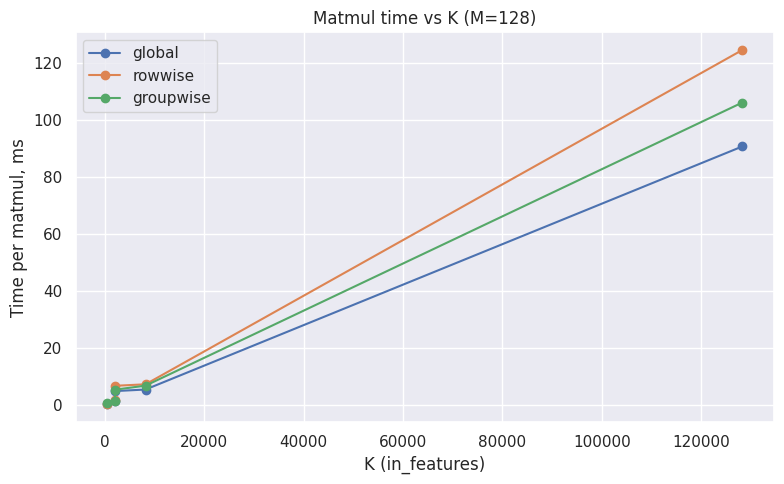

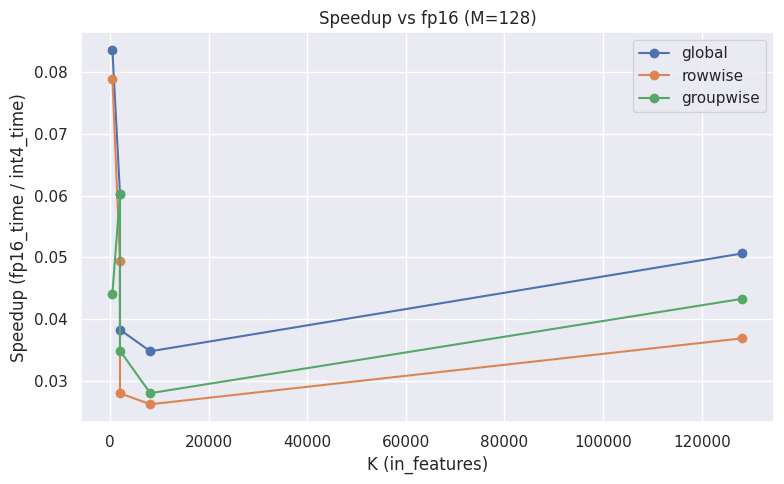

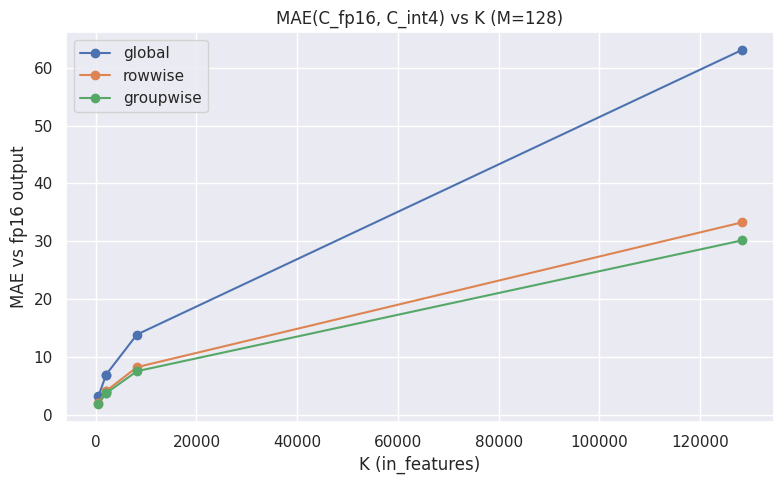

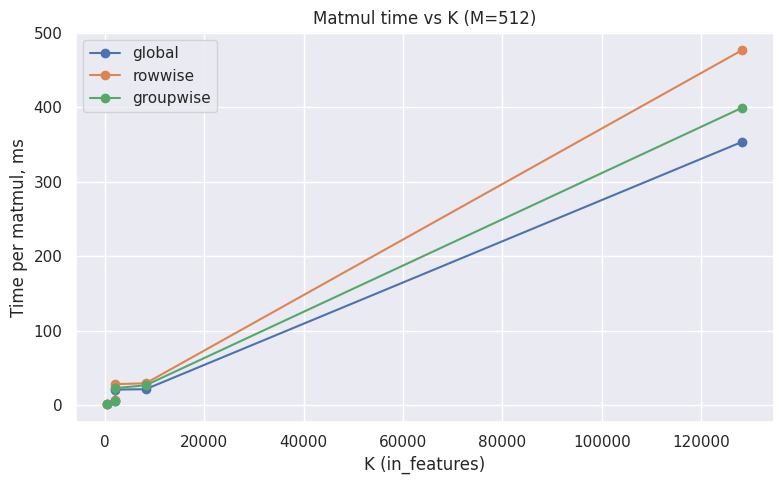

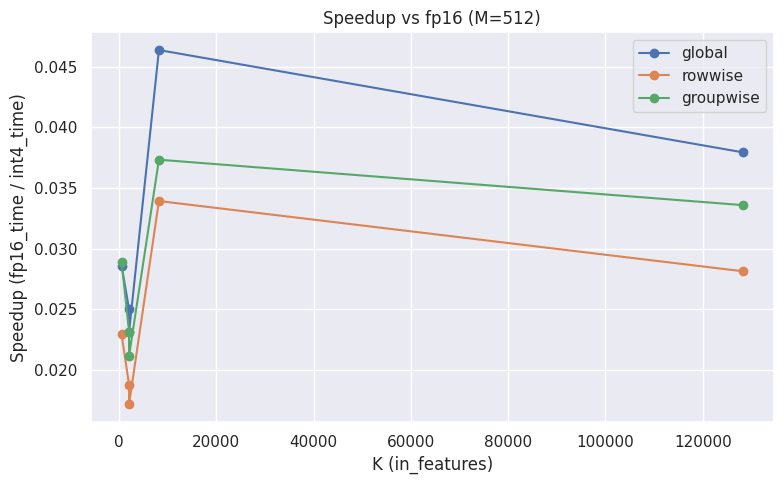

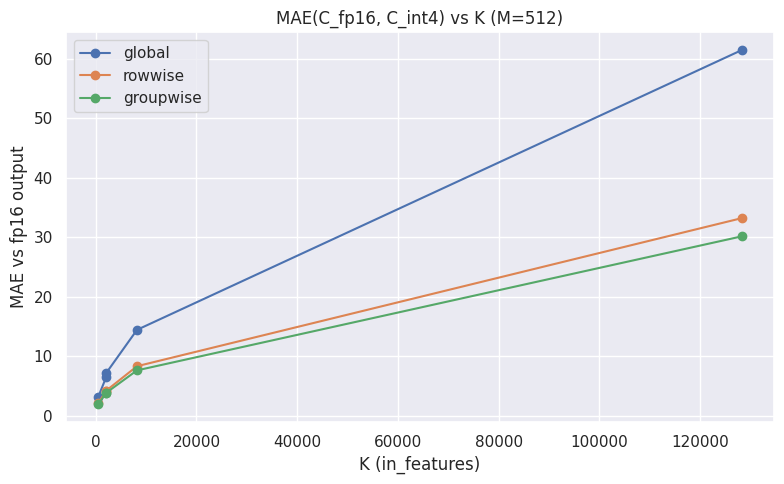

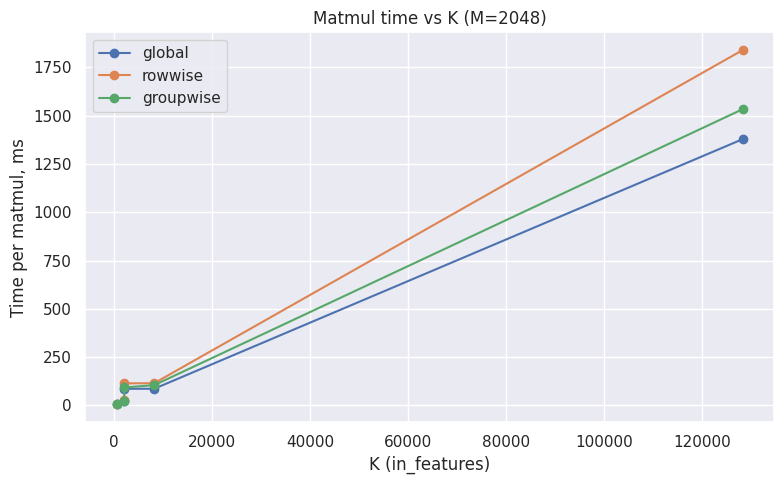

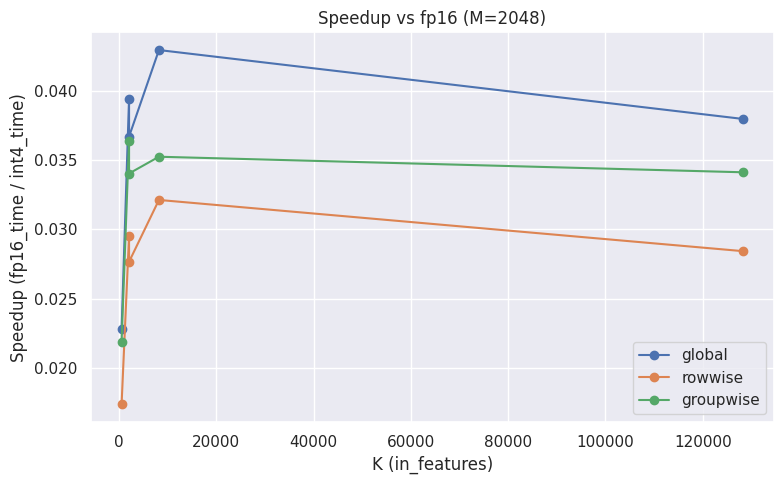

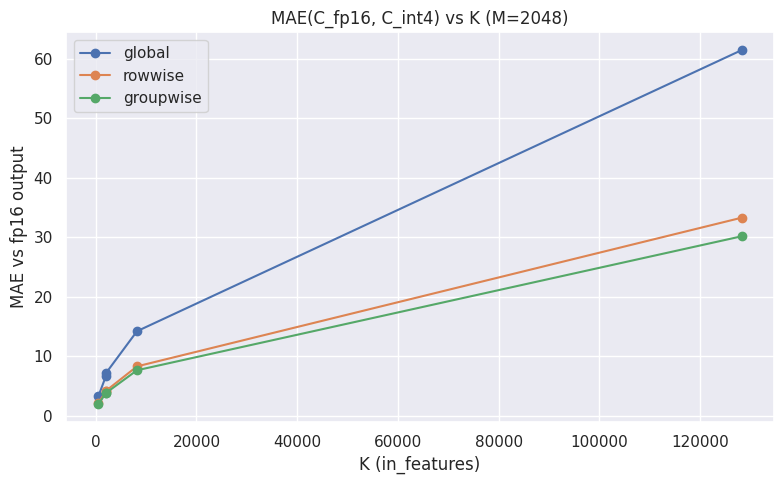

In [11]:
# ------------------------------------------------------------
# Графики: время и speedup
# ------------------------------------------------------------

modes = ["global", "rowwise", "groupwise"]

for M in token_counts:
    df_M = df[df["M"] == M]

    # ---- График времени от K (для каждого режима) ----
    plt.figure(figsize=(8, 5))
    for mode in modes:
        df_M_mode = df_M[(df_M["mode"] == mode)]
        plt.plot(
            df_M_mode["K"],
            df_M_mode["time_ms"],
            marker="o",
            label=mode,
        )
    plt.title(f"Matmul time vs K (M={M})")
    plt.xlabel("K (in_features)")
    plt.ylabel("Time per matmul, ms")
    # plt.xscale("log")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    # ---- График speedup vs K ----
    plt.figure(figsize=(8, 5))
    for mode in modes:
        df_M_mode = df_M[(df_M["mode"] == mode)]
        plt.plot(
            df_M_mode["K"],
            df_M_mode["speedup_vs_fp16"],
            marker="o",
            label=mode,
        )
    plt.title(f"Speedup vs fp16 (M={M})")
    plt.xlabel("K (in_features)")
    # plt.xscale("log")
    plt.ylabel("Speedup (fp16_time / int4_time)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    # ---- График ошибок (MAE) vs K ----
    plt.figure(figsize=(8, 5))
    for mode in modes:
        df_M_mode = df_M[(df_M["mode"] == mode)]
        plt.plot(
            df_M_mode["K"],
            df_M_mode["mae_vs_fp16"],
            marker="o",
            label=mode,
        )
    plt.title(f"MAE(C_fp16, C_int4) vs K (M={M})")
    plt.xlabel("K (in_features)")
    plt.ylabel("MAE vs fp16 output")
    # plt.xscale("log")
    plt.grid(True, which="both")
    plt.legend()
    plt.tight_layout()

plt.show()

# 4. С использованием написанных кернелей написать квантизованный линейный слой и применить его к линейным слоям модели Llama-3.2-1B-Instruct

In [ ]:
from kernels.quant_linear import QuantLinearInt4, quantize_all_linears

In [ ]:
# ------------------------------------------------------------
# Перплексия на WikiText-2
# ------------------------------------------------------------
def encode_wikitext2(tokenizer, max_length: int = 1024) -> List[torch.Tensor]:
    wikitext = load_dataset("wikitext", "wikitext-2-raw-v1")
    test_texts = wikitext["test"]["text"]
    full_text = "\n\n".join(test_texts)
    tokens = tokenizer(full_text, return_tensors="pt")["input_ids"][0]
    chunks = []
    for i in range(0, len(tokens) - max_length, max_length):
        chunks.append(tokens[i : i + max_length])
    return chunks


def compute_perplexity(
    model: AutoModelForCausalLM,
    chunks: List[torch.Tensor],
    device: str = "cuda",
    max_chunks: Optional[int] = None,
) -> float:
    model.eval()
    nll_sum = 0.0
    n_tokens = 0

    if max_chunks is not None:
        chunks = chunks[:max_chunks]

    with torch.no_grad():
        for chunk in chunks:
            input_ids = chunk.unsqueeze(0).to(device)  # [1, T]
            labels = input_ids.clone()
            outputs = model(input_ids=input_ids, labels=labels)
            loss = outputs.loss
            nll = loss.item() * input_ids.size(1)
            nll_sum += nll
            n_tokens += input_ids.size(1)

    avg_nll = nll_sum / n_tokens
    ppl = math.exp(avg_nll)
    return ppl


# ------------------------------------------------------------
# Замер inference speed (tokens/sec)
# ------------------------------------------------------------
def benchmark_tokens_per_sec(
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    seq_len: int,
    num_iters: int = 20,
    device: str = "cuda",
    prompt_text: str = "",
) -> float:
    model.eval()
    model.to(device)

    if not prompt_text:
        prompt_text = (
            "In a galaxy far, far away, a small group of rebels "
            "stood against the mighty empire, knowing that hope "
            "was the most powerful weapon they had."
        )

    inputs = tokenizer(
        prompt_text,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=seq_len,
    ).to(device)

    # Warmup
    with torch.inference_mode():
        for _ in range(5):
            _ = model(**inputs)

    torch.cuda.synchronize()
    start = time.time()
    with torch.inference_mode():
        for _ in range(num_iters):
            _ = model(**inputs)
    torch.cuda.synchronize()
    elapsed = (time.time() - start) / num_iters  # sec per forward

    tokens_per_forward = seq_len * inputs["input_ids"].size(0)
    tokens_per_sec = tokens_per_forward / elapsed
    return tokens_per_sec

In [18]:
device = "cuda"
model_name = "unsloth/Llama-3.2-1B-Instruct"

print("Loading tokenizer and fp16 model...")
tokenizer = AutoTokenizer.from_pretrained(model_name)
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="cuda",
)
base_model.eval()

# Квантованные модели для всех режимов
quant_modes = {
    "fp16": None,  # оригинал
    "global": {"mode": "global", "group_size": None},
    "rowwise": {"mode": "rowwise", "group_size": None},
    "groupwise": {"mode": "groupwise", "group_size": 128},
}

models = {"fp16": base_model}

print("Creating quantized model copies...")
for qname, cfg in quant_modes.items():
    if qname == "fp16":
        continue
    print(f"  -> Building {qname} model...")
    qm = copy.deepcopy(base_model).to(device)
    quantize_all_linears(qm, mode=cfg["mode"], group_size=cfg["group_size"])
    qm.eval()
    models[qname] = qm

Loading tokenizer and fp16 model...


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

Creating quantized model copies...
  -> Building global model...
  -> Building rowwise model...
  -> Building groupwise model...


In [ ]:
# --------------------------------------------------------
# Перплексия на WikiText-2
# --------------------------------------------------------
chunks = encode_wikitext2(tokenizer)

ppl_results = []
for name, mdl in models.items():
    print(f"  -> {name}")
    ppl = compute_perplexity(mdl, chunks, device=device)
    ppl_results.append({"mode": name, "perplexity": ppl})
    print(f"     PPL = {ppl:.3f}")

ppl_df = pd.DataFrame(ppl_results)
print("\nPerplexity results:")
display(ppl_df)

In [ ]:
ppl_df.to_csv("data/llama_quant_ppl.csv", index=False)

In [ ]:
# --------------------------------------------------------
# Inference speed: tokens/sec
# --------------------------------------------------------
speed_rows = []
for name, mdl in models.items():
    print(f"  -> {name}")
    tps = benchmark_tokens_per_sec(
        mdl,
        tokenizer,
        seq_len=1024,
        num_iters=10,
        device=device,
    )
    speed_rows.append(
        {
            "mode": name,
            "tokens_per_sec": tps,
        }
    )
    print(f"     {tps:.1f} tokens/sec")

speed_df = pd.DataFrame(speed_rows)
print("\nSpeed results (tokens/sec):")
display(speed_df)

  -> fp16
     7761.3 tokens/sec
  -> global
     331.1 tokens/sec
  -> rowwise
     247.6 tokens/sec
  -> groupwise
     295.6 tokens/sec

Speed results (tokens/sec):


,mode,tokens_per_sec
0,fp16,7761.302261
1,global,331.114071
2,rowwise,247.640887
3,groupwise,295.557271


In [ ]:
speed_df.to_csv("data/llama_quant_speed.csv", index=False)

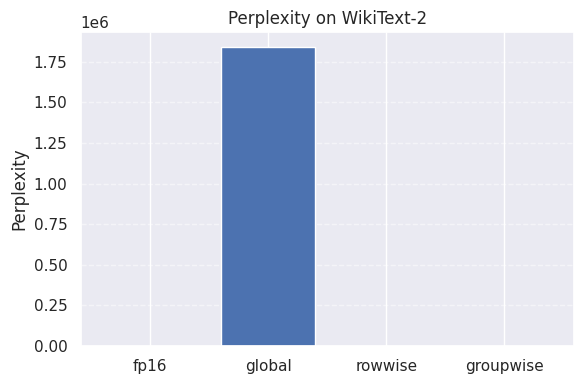

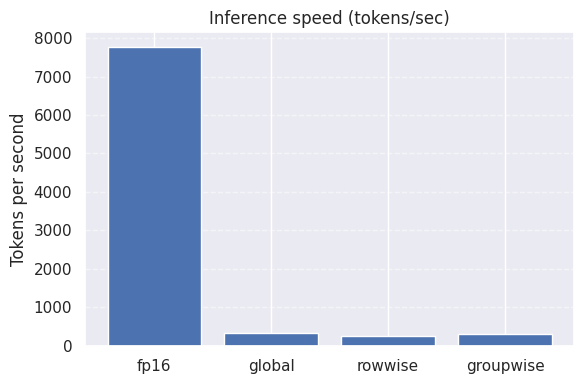

In [27]:
# --------------------------------------------------------
# Графики
# --------------------------------------------------------
# Перплексия по режимам
plt.figure(figsize=(6, 4))
plt.bar(ppl_df["mode"], ppl_df["perplexity"])
plt.title("Perplexity on WikiText-2")
plt.ylabel("Perplexity")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("ppl_barplot.png", dpi=150)

# tokens/sec
plt.figure(figsize=(6, 4))
plt.bar(speed_df["mode"], speed_df["tokens_per_sec"])
plt.title("Inference speed (tokens/sec)")
plt.ylabel("Tokens per second")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("tokens_per_sec.png", dpi=150)

plt.show()

In [ ]:
# ====== функции для подсчёта размера ======


def tensor_nbytes(t: torch.Tensor | None) -> int:
    if t is None:
        return 0
    return t.numel() * t.element_size()


def get_model_size_bytes(model: nn.Module) -> int:
    """Считает суммарный размер всех параметров (parameters) и буферов (buffers) в байтах."""
    total = 0
    for p in model.parameters():
        total += tensor_nbytes(p.data)
    for b in model.buffers():
        total += tensor_nbytes(b)
    return total


def get_linear_size_bytes(model: nn.Module) -> int:
    """Считает размер только линейных слоёв (nn.Linear + QuantLinearInt4) в байтах."""
    total = 0
    for module in model.modules():
        if isinstance(module, nn.Linear):
            total += tensor_nbytes(module.weight)
            total += tensor_nbytes(module.bias)
        elif isinstance(module, QuantLinearInt4):
            # b_packed (int32) + meta (fp16/fp32) + bias (fp16)
            total += tensor_nbytes(module.b_packed)
            total += tensor_nbytes(module.meta)
            total += tensor_nbytes(module.bias)
    return total


# ====== пример: считаем сжатие при rowwise-квантовании линейных слоёв ======
model_name = "unsloth/Llama-3.2-1B-Instruct"

print("Loading fp16 model...")
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="cuda",
)
base_model.eval()

# Полный размер исходной модели
base_total_bytes = get_model_size_bytes(base_model)
base_linear_bytes = get_linear_size_bytes(base_model)

print(f"Base model total size:  {base_total_bytes / (1024**2):.2f} MB")
print(f"Base linear weights:    {base_linear_bytes / (1024**2):.2f} MB")

# Квантованная копия (rowwise)
print("Building rowwise-quantized model (only linear layers)...")
quant_model = copy.deepcopy(base_model)
quantize_all_linears(quant_model, mode="rowwise", group_size=None)
quant_model.eval()

quant_total_bytes = get_model_size_bytes(quant_model)
quant_linear_bytes = get_linear_size_bytes(quant_model)

print(f"\nRowwise model total size: {quant_total_bytes / (1024**2):.2f} MB")
print(f"Rowwise linear weights:   {quant_linear_bytes / (1024**2):.2f} MB")

# Коэффициенты сжатия
total_compression = base_total_bytes / quant_total_bytes
linear_compression = base_linear_bytes / quant_linear_bytes

print("\n=== Compression ratios (rowwise int4 for linear layers) ===")
print(f"Total model compression:   {total_compression:.3f}x")
print(f"Linear layers compression: {linear_compression:.3f}x")


In [ ]:
# Base model total size:  2357.13 MB
# Base linear weights:    2357.00 MB
# Building rowwise-quantized model (only linear layers)...

# Rowwise model total size: 1091.34 MB
# Rowwise linear weights:   590.21 MB

# === Compression ratios (rowwise int4 for linear layers) ===
# Total model compression:   2.160x
# Linear layers compression: 3.993x